In [1]:
# necessary packages to import 
import numpy as np

In [1]:
'''
Examples:
1. submit structures to aiida workchains
2. read data from aiida workchains as AiidaMofs object
3. two ways to plot results
'''


from isotherm import generateconfig, submit_mof, submit_mofs

ff_data = "UFF.json"
cif_path = "/home/yutao/project/Al-MOF/mil121/RSM0112.cif"
isotherm_path = "/home/yutao/project/Al-MOF/mil121/273K.csv"
output_name = "test.log"
temperature = 303
data = np.loadtxt(isotherm_path, delimiter=',')
pressure_list = list(data[:,0])
generateconfig(ff_data, temperature, pressure_list, cif_path, output_name)
submit_mof(output_name)

# submit workchains for all mofs in structure_path
structure_path = "/home/yutao/project/Al-MOF/"
ff_data = "try_0226.json"
submit_mofs(structure_path, ff_data)

As long as it finishes, 0
The tested force field is:  UFF.json
The tested cif is:  /home/yutao/project/Al-MOF/mil121/RSM0112.cif
The simulation temperature is:  303
This is the final pk values for isotherm workflow:  820282



In [1]:
from aiidamof import AiidaMofs, plot_isotherm
import numpy as np
log_name = "In_CO_all_In.log"
aiidamofs = AiidaMofs(log_name)

This is 810398 None
This is 810417 None
This is 810434 None
This is 810453 None
This is 810472 None
This is 810489 None
This is 810506 None
This is 810523 None
This is 810542 None
This is 810559 None
This is 810578 None


In [3]:
from utils import extract_ff
element_list = ["In_", "C_", "H_", "O_","N_"]
extract_ff("InN",842277, element_list)

/home/yutao/project/aiida/applications/InN.json has been written
/home/yutao/project/aiida/applications/InN.xml has been written


{'In_': ['lennard-jones', 301.4595, 3.9761],
 'C_': ['lennard-jones', 12.012148846072, 3.4309],
 'H_': ['lennard-jones', 22.151264729937, 2.5711],
 'O_': ['lennard-jones', 4.1285586546958, 3.1181],
 'N_': ['lennard-jones', 34.7257, 3.26071]}

Wrong output dict, num: 1, in workchain 778663, CPM-203
UFF
778558
/home/yutao/project/Mg-MOF/MOF-889
RSM3831.cif
UFF
778602
/home/yutao/project/Mg-MOF/CPM-201
RSM3545.cif
UFF
778646
/home/yutao/project/Mg-MOF/CPM-203
RSM0100.cif
UFF
778692
/home/yutao/project/Mg-MOF/HAFVUH
RSM0639.cif


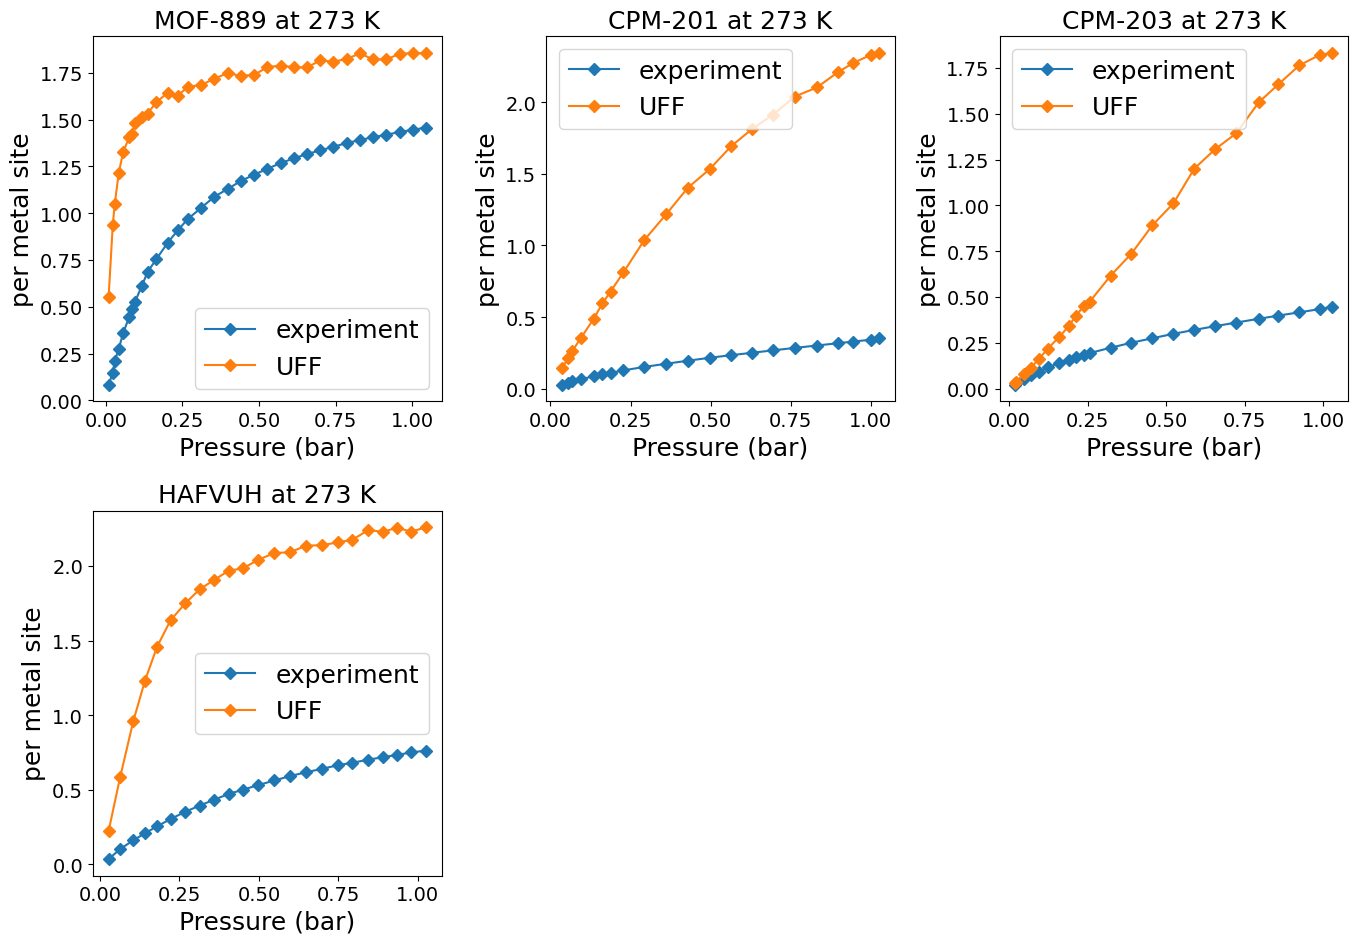

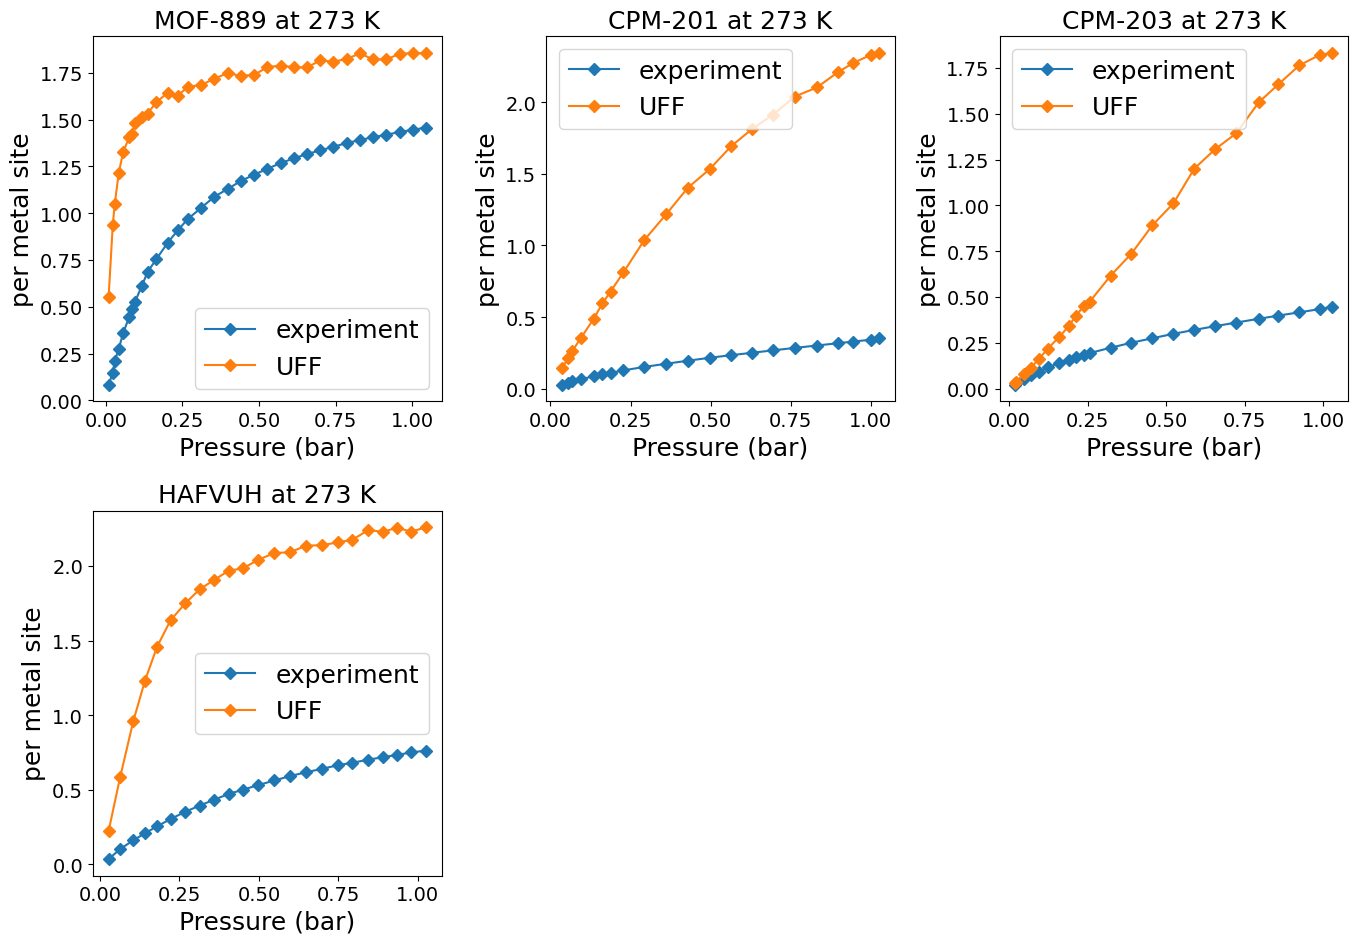

In [2]:
from aiidamof import AiidaMofs, plot_isotherm
import numpy as np
log_name = "UFF_Mg.log"
aiida_mofs = AiidaMofs(log_name)
# Get an AiidaMof object
aiida_mof = aiida_mofs[0]
# Print the folder of the AiidaMof object
for aiida_mof in aiida_mofs:
    print(aiida_mof.forcefield)
    print(aiida_mof.isotherm_pk)
    print(aiida_mof.folder)
    print(aiida_mof.cifname)
plot_isotherm(aiida_mofs)

Isotherm workflow failed for  848387 MIL120
meet error in extract data from structure MIL120
Isotherm workflow failed for  848404 cau21bpdc
meet error in extract data from structure cau21bpdc
Isotherm workflow failed for  848455 nott300
meet error in extract data from structure nott300
Isotherm workflow failed for  848506 cau10-OCH3
meet error in extract data from structure cau10-OCH3
Isotherm workflow failed for  848523 cau10H
meet error in extract data from structure cau10H
Isotherm workflow failed for  848541 mil121
meet error in extract data from structure mil121


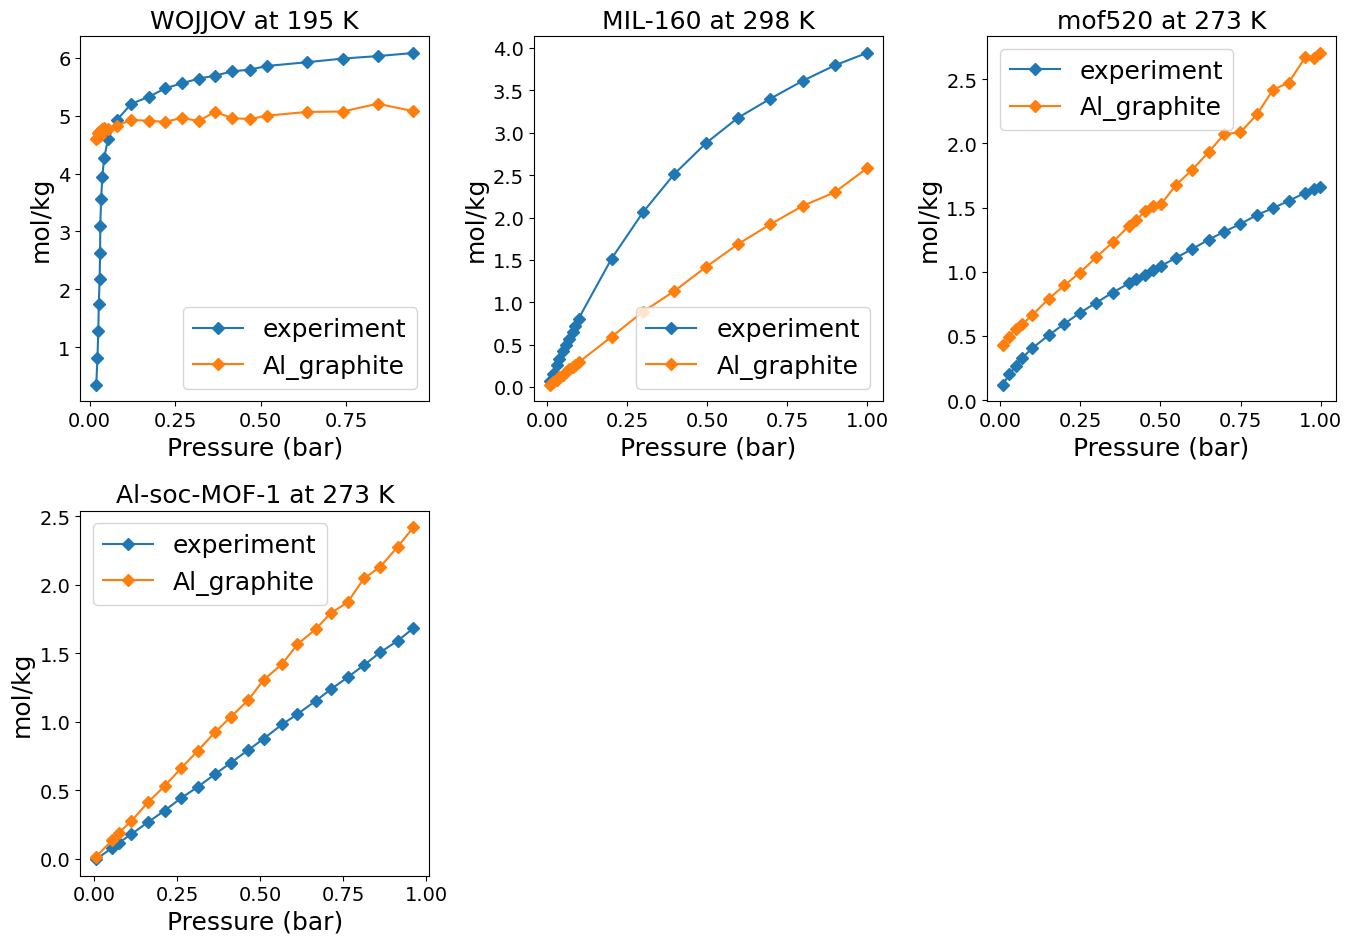

In [8]:
from aiidamof import AiidaMofs, plot_isotherm
import numpy as np
for log_name in ["Al_graphite_0527_08.log"]:
    aiida_mofs = AiidaMofs(log_name)
    plot_isotherm(aiida_mofs)

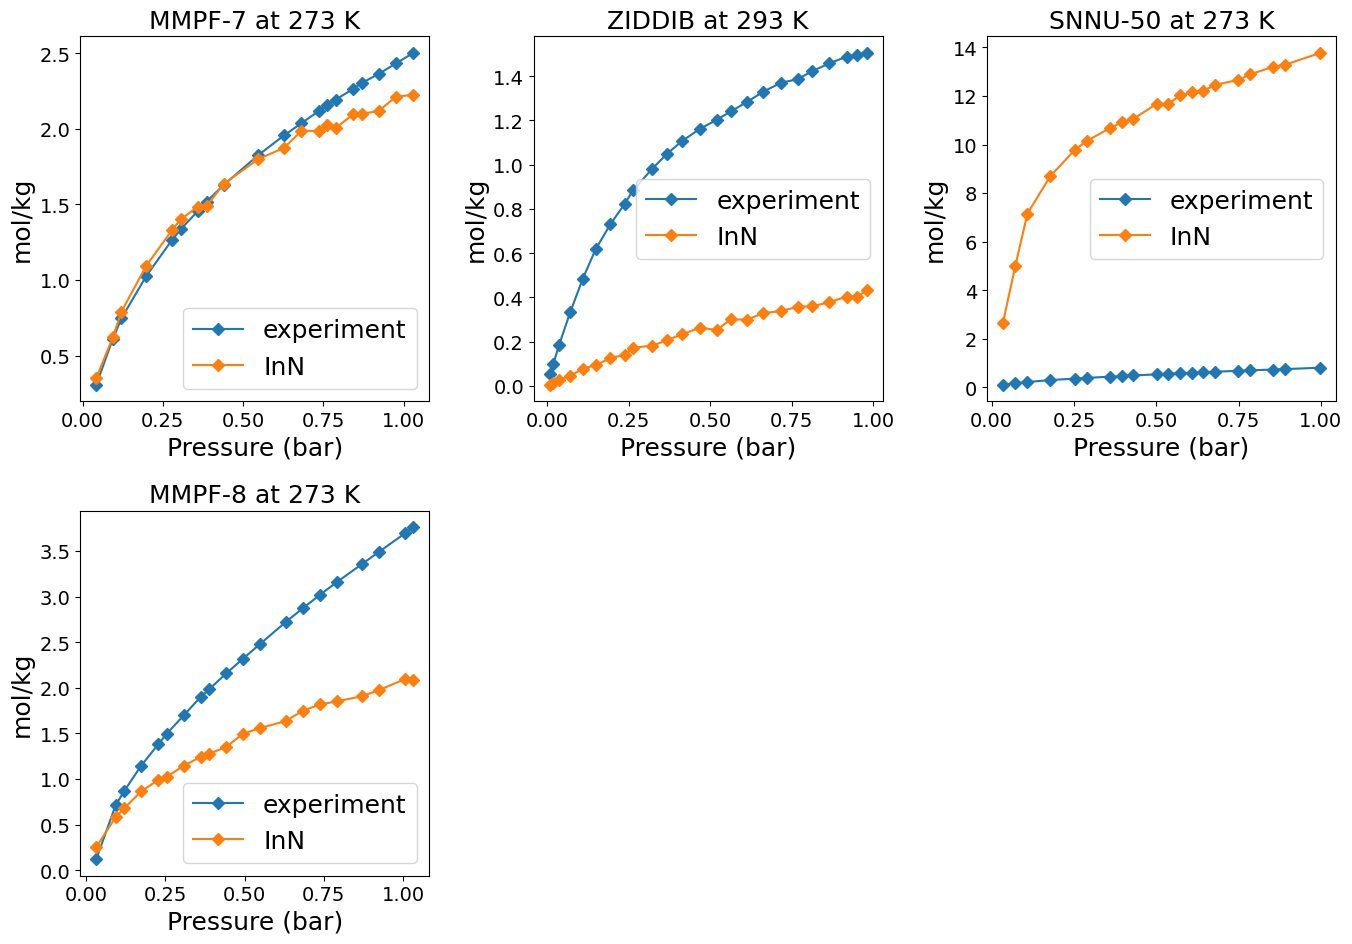

Isotherm workflow failed for  852533 MMPF-8
meet error in extract data from structure MMPF-8


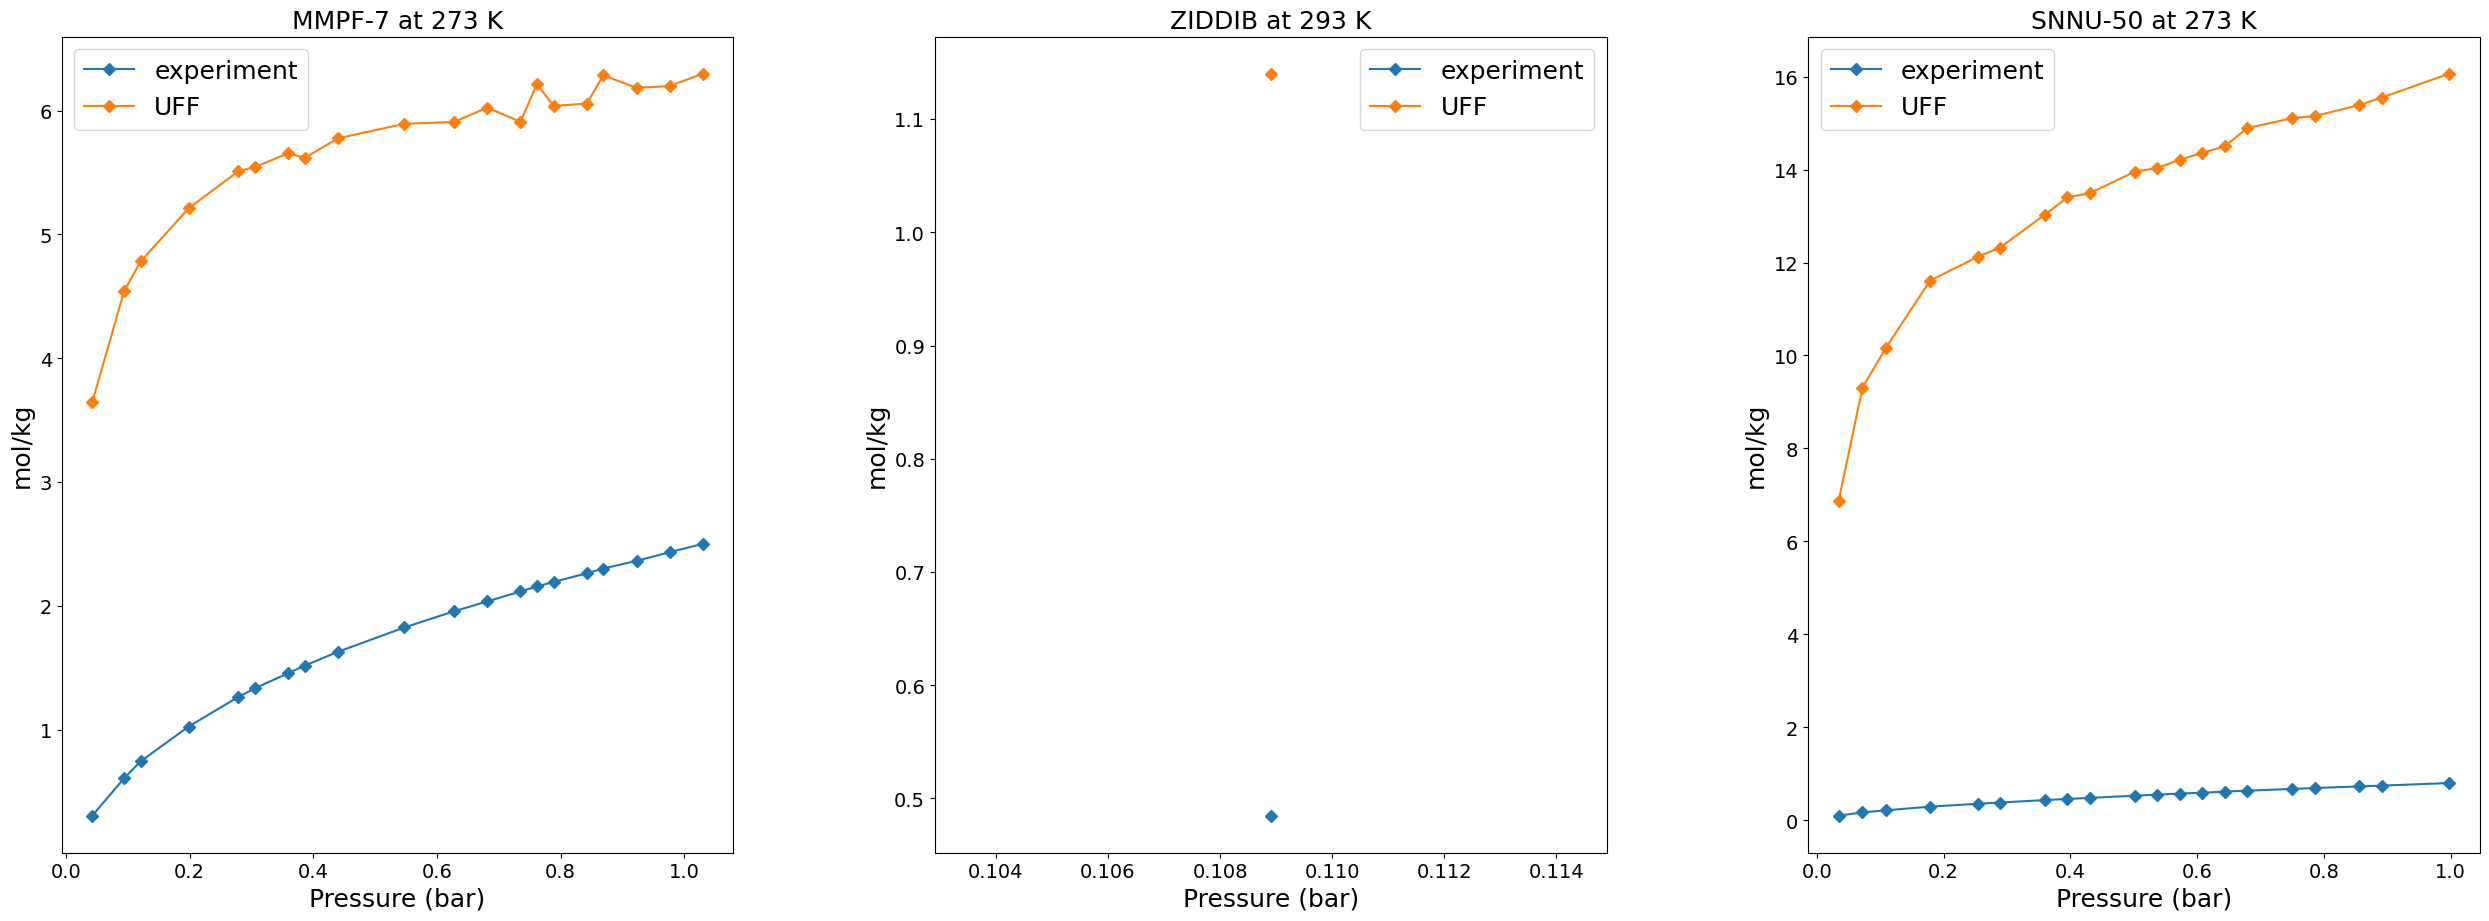

Isotherm workflow failed for  854038 MMPF-8
meet error in extract data from structure MMPF-8


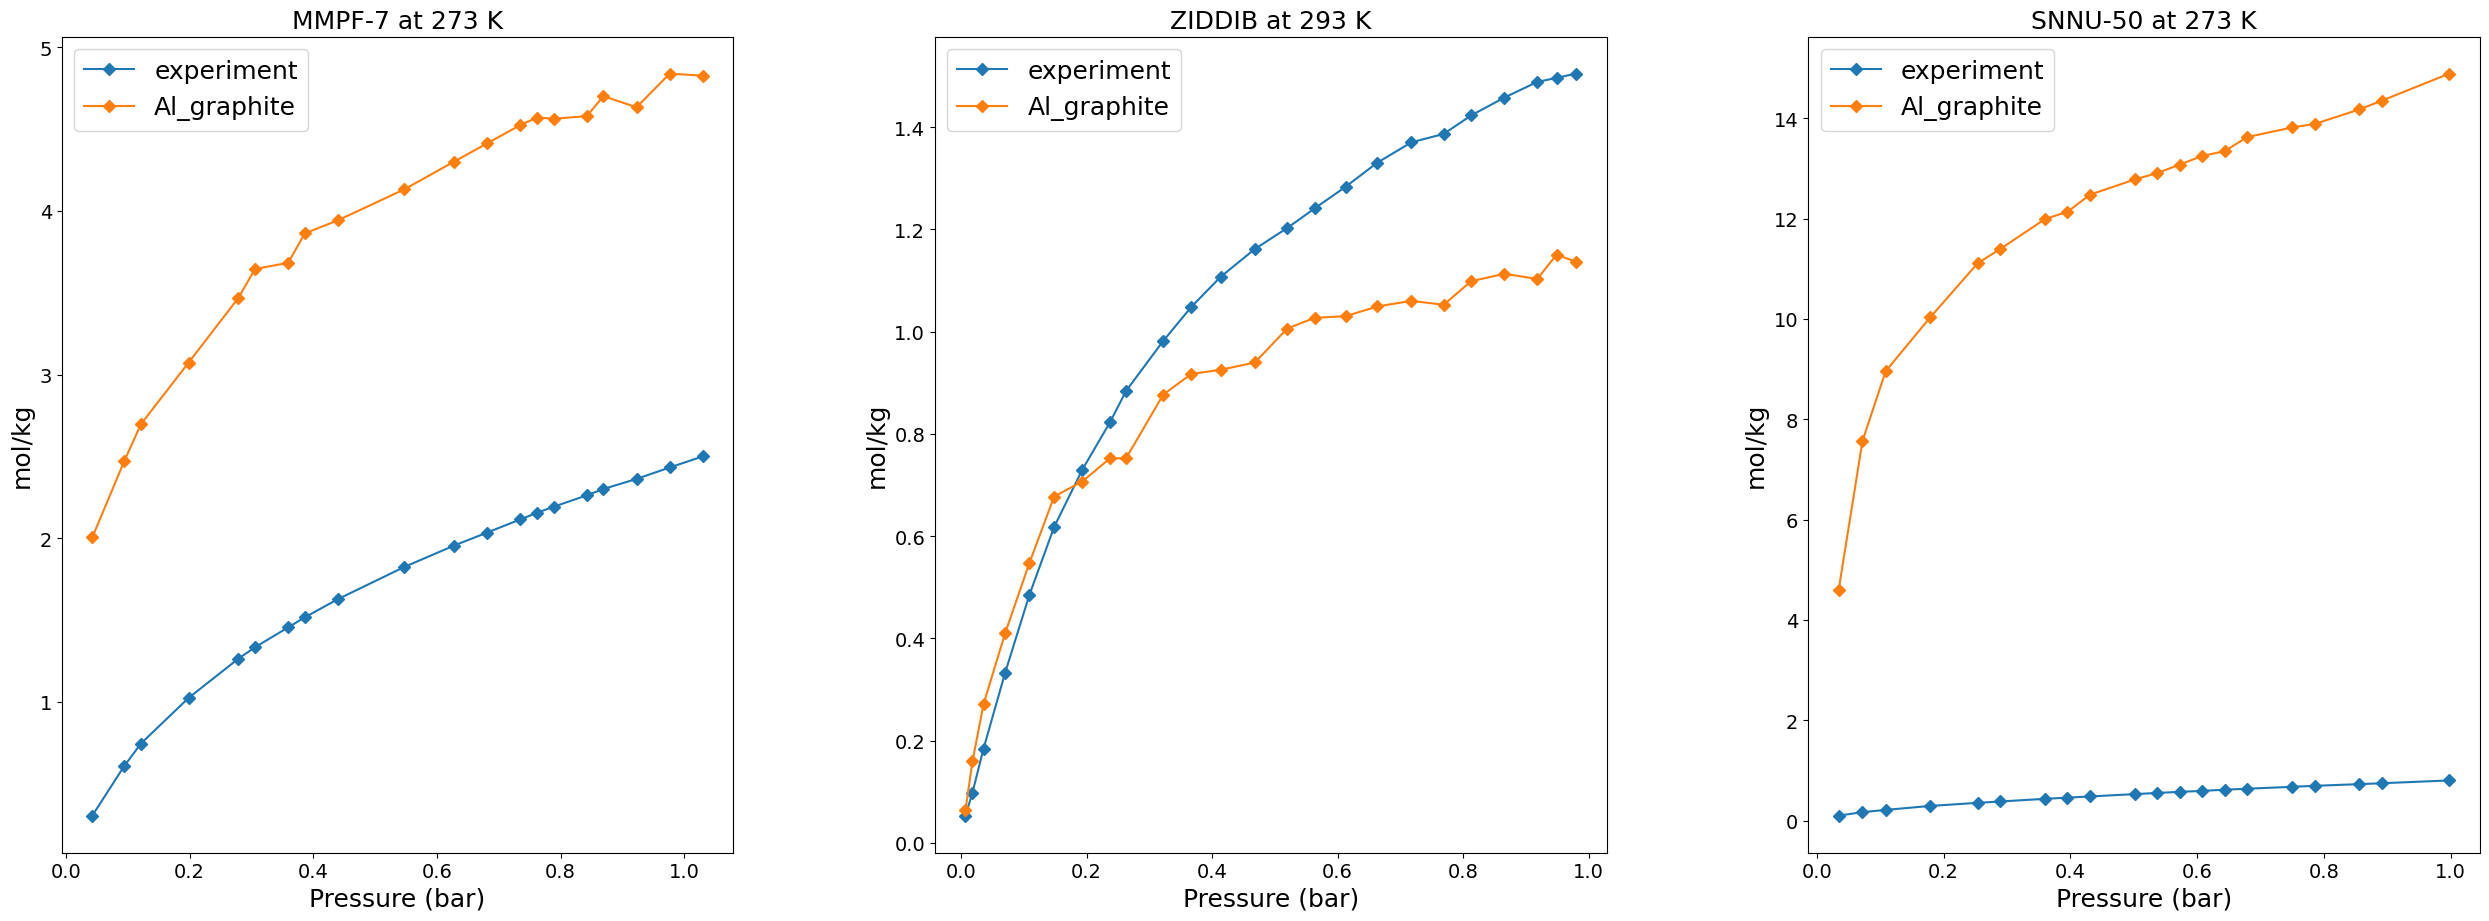

In [1]:
from aiidamof import AiidaMofs, plot_isotherm
import numpy as np
for log_name in ["InN_InN_new_short.log", "UFF_InN_0527_short.log", "Al_graphite_InN_new_short.log"]:
    aiida_mofs = AiidaMofs(log_name)
    plot_isotherm(aiida_mofs)

In [13]:
for aiida_mof in aiida_mofs:
    print(aiida_mof.mofname)

MMPF-7
ZIDDIB
SNNU-50
MMPF-8


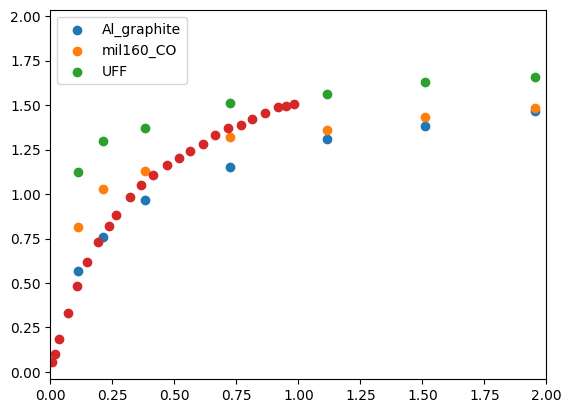

In [21]:
import matplotlib.pyplot as plt
for log_name in ["Al_graphite_InN-MOF.log",  "mil160_CO_InN-MOF.log","UFF_InN-MOF.log"]:
    aiida_mofs = AiidaMofs(log_name)
    aiida_mof = aiida_mofs[1]
    plt.scatter(aiida_mof.ff_pressure, aiida_mof.ff_loading, label = aiida_mof.forcefield)
plt.scatter(aiida_mof.exp_pressure, aiida_mof.exp_loading)
plt.xlim(0,2)
plt.legend()

In [3]:
34.7257/(254.152/2.11525)

0.2890141998685826

In [ ]:
from aiidamof import AiidaMofs, plot_isotherm
import numpy as np
for log_name in ["UFF_Cu.log", "In_CO_Cu.log", "Cu_CO_Cu.log"]:
    aiida_mofs = AiidaMofs(log_name)
    plot_isotherm(aiida_mofs)

In [10]:
log_name = "In_CO_all_In.log"
aiidamofs = AiidaMofs(log_name)

meet error in extract data from structure OTEHAY
meet error in extract data from structure InOF-13
meet error in extract data from structure JUC-101
meet error in extract data from structure REYJEM
meet error in extract data from structure CPM-12
meet error in extract data from structure MFM-300
meet error in extract data from structure mil-68
meet error in extract data from structure EQUNEL
meet error in extract data from structure GALJAG
meet error in extract data from structure SUQJEV
meet error in extract data from structure SUQHUJ


Wrong output dict, num: 1, in binding site workchain 648767, Cu-MOF-1
meet error in extract data from structure NU-111


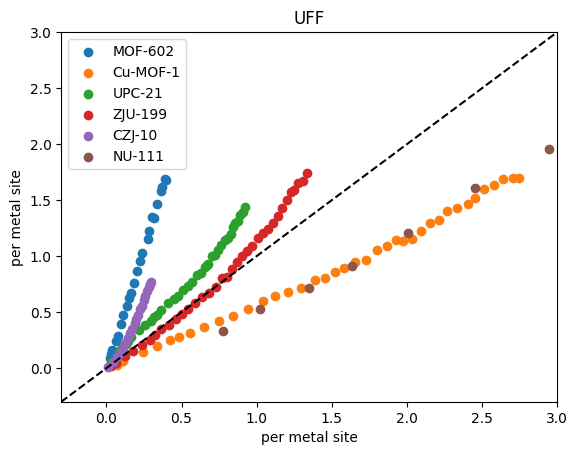

In [5]:
Isotherm_unit = "per metal site" 

import matplotlib.pyplot as plt
import numpy as np

aiidamofs = AiidaMofs("UFF_Cu.log")
max_loading = 3
FF_name = aiidamofs[0].forcefield
# plot reference
plt.plot(np.linspace(-max_loading, max_loading, 100), np.linspace(-max_loading, max_loading, 100), 'k--')
# plot point
for aiidamof in aiidamofs:
    if aiidamof.co_isotherms:
        plt.scatter(aiidamof.co_isotherms["experiment"], aiidamof.co_isotherms[FF_name], label=aiidamof.mofname)
plt.xlim(-0.1*max_loading, max_loading)
plt.ylim(-0.1*max_loading, max_loading)
plt.xlabel(Isotherm_unit)
plt.ylabel(Isotherm_unit)
plt.title(FF_name)
plt.legend()
plt.show()

This is 810398 None
This is 810417 None
This is 810434 None
This is 810453 None
This is 810472 None
This is 810489 None
This is 810506 None
This is 810523 None
This is 810542 None
This is 810559 None
This is 810578 None


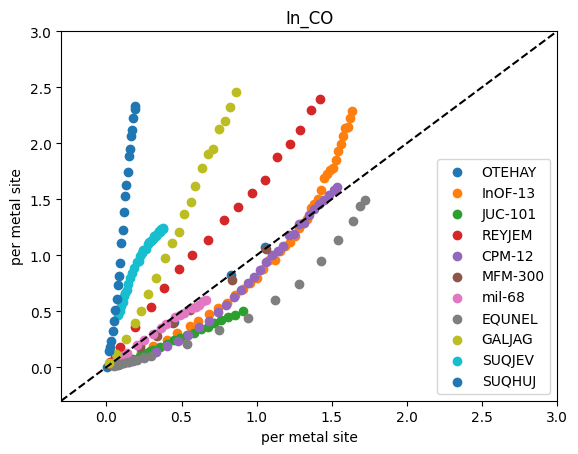

In [4]:
Isotherm_unit = "per metal site" 

import matplotlib.pyplot as plt
import numpy as np

aiidamofs = AiidaMofs("In_CO_all_In.log")
max_loading = 3
FF_name = aiidamofs[0].forcefield
# plot reference
plt.plot(np.linspace(-max_loading, max_loading, 100), np.linspace(-max_loading, max_loading, 100), 'k--')
# plot point
for aiidamof in aiidamofs:
    if aiidamof.co_isotherms:
        plt.scatter(aiidamof.co_isotherms["experiment"], aiidamof.co_isotherms[FF_name], label=aiidamof.mofname)
plt.xlim(-0.1*max_loading, max_loading)
plt.ylim(-0.1*max_loading, max_loading)
plt.xlabel(Isotherm_unit)
plt.ylabel(Isotherm_unit)
plt.title(FF_name)
plt.legend()
plt.show()

In [3]:
from aiidamof import AiidaMofs, plot_isotherm
import numpy as np

Isotherm_unit = "per metal site" 

import matplotlib.pyplot as plt
import numpy as np

for log_name in ["UFF_Cu.log", "In_CO_Cu.log", "Cu_CO_Cu.log", "In_CO_all_In.log"]:
    aiidamofs = AiidaMofs(log_name)
    max_loading = 3
    FF_name = aiidamofs[0].forcefield
    # plot reference
    plt.plot(np.linspace(-max_loading, max_loading, 100), np.linspace(-max_loading, max_loading, 100), 'k--')
    # plot point
    for aiidamof in aiidamofs:
        if aiidamof.co_isotherms:
            plt.scatter(aiidamof.co_isotherms["experiment"], aiidamof.co_isotherms[FF_name], label=aiidamof.mofname)
    plt.xlim(-0.1*max_loading, max_loading)
    plt.ylim(-0.1*max_loading, max_loading)
    plt.xlabel(Isotherm_unit)
    plt.ylabel(Isotherm_unit)
    plt.title(FF_name)
    plt.legend()
    plt.show()

This is 648705 648721
This is 648751 648767
Wrong output dict, num: 1, in binding site workchain 648767, Cu-MOF-1
This is 648796 648813
This is 648842 648860
This is 648889 648906
This is 651071 651087
This is 651119 651136
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/yutao/.aiida_venvs/aiida/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2423127/2632859644.py", line 10, in <module>
    aiidamofs = AiidaMofs(log_name)
  File "/home/yutao/project/github/ff_optimizer/sampler/aiidamof.py", line 170, in __init__
    def __len__(self):
  File "/home/yutao/project/github/ff_optimizer/sampler/aiidamof.py", line 183, in extractdata
  File "/home/yutao/project/github/ff_optimizer/sampler/aiidamof.py", line 156, in extractdata
    self.set_isotherm()
  File "/home/yutao/project/github/ff_optimizer/sampler/aiidamof.py", line 118, in set_isotherm
    exp_isotherm = np.loadtxt(exp_path, delimiter=',')
  File "/home/yutao/.aiida_venvs/aiida/lib/python3.9/site-packages/numpy/lib/npyio.py", line 1308, in loadtxt
    arr = _read(fname, dtype=dtype, comment=comment, delimiter=delimiter,
  File "/home/yuta

In [2]:
1

1

Wrong output dict, num: 1, in binding site workchain 781772, mof520
Wrong output dict, num: 1, in binding site workchain 781824, Al-soc-MOF-1
Wrong output dict, num: 1, in binding site workchain 781963, mil121
Wrong output dict, num: 1, in binding site workchain 782259, mof520
Wrong output dict, num: 1, in binding site workchain 782308, Al-soc-MOF-1
Wrong output dict, num: 1, in binding site workchain 782452, mil121


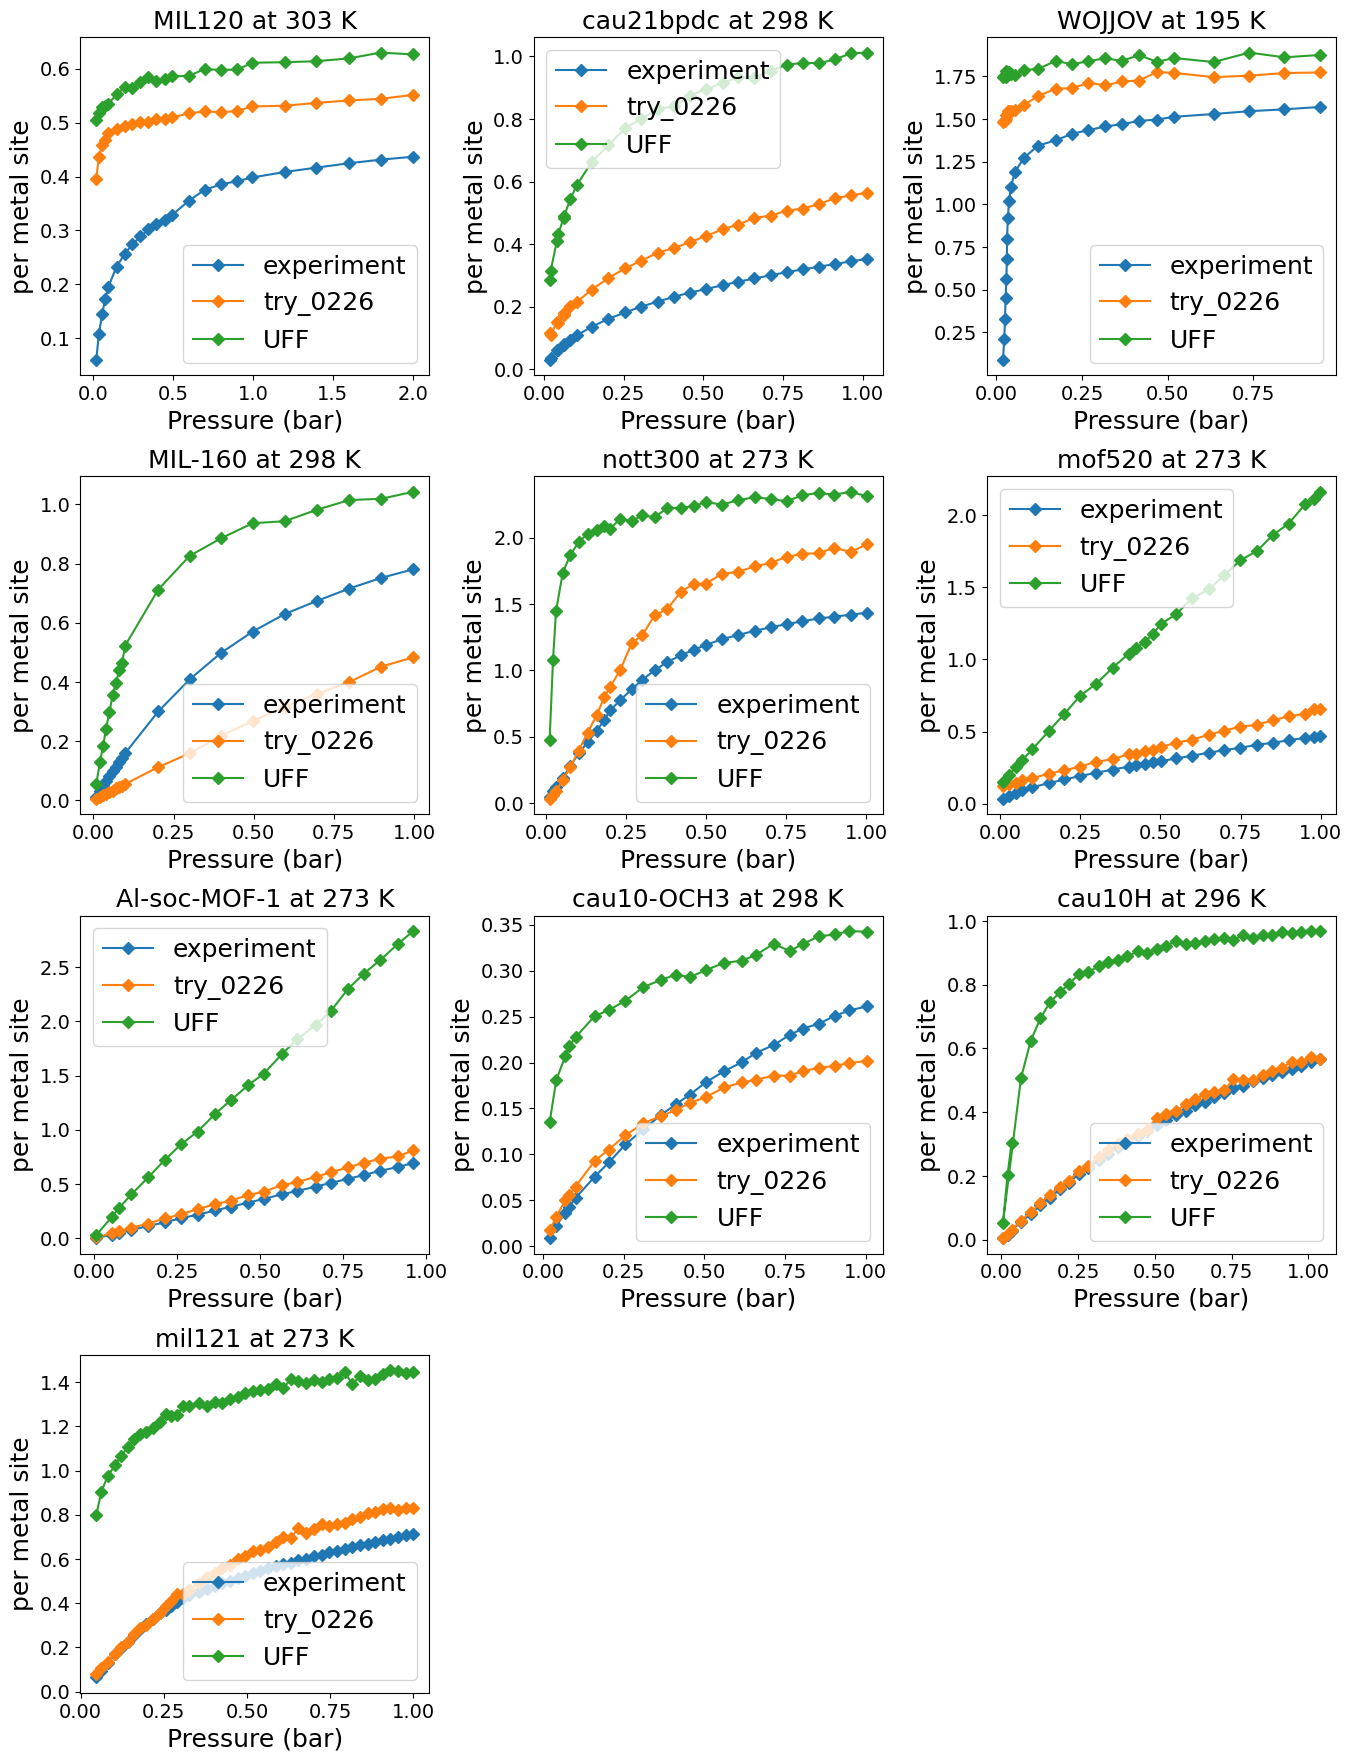

In [2]:
from aiidamof import AiidaMofs, plot_isotherm
from aiidamof import merge_aiida_mofs

UFF_logfile = "UFF_Al_0430.log"
newFF_logfile = "try_0226_Al_0430.log"
aiidamofs = merge_aiida_mofs(AiidaMofs(newFF_logfile),AiidaMofs(UFF_logfile))
plot_isotherm(aiidamofs)

In [ ]:
from aiidamof import AiidaMofs, plot_isotherm
from aiidamof import merge_aiida_mofs

UFF_logfile = "UFF_Al_0430.log"
newFF_logfile = "try_0226_Al_0430.log"
aiidamofs = merge_aiida_mofs(AiidaMofs(newFF_logfile),AiidaMofs(UFF_logfile))
plot_isotherm(aiidamofs)

In [2]:
["UFF_Cu.log", "In_CO_Cu.log", "Cu_CO_Cu.log"]

['UFF_Cu.log', 'In_CO_Cu.log', 'Cu_CO_Cu.log']

Wrong output dict, num: 1, in binding site workchain 690503, UTSA-68
Wrong output dict, num: 1, in binding site workchain 690551, UTSA-28-Cu
Wrong output dict, num: 1, in binding site workchain 690606, NU-111
Wrong output dict, num: 1, in binding site workchain 690749, Cu-MOF-1
Wrong output dict, num: 1, in binding site workchain 690902, HKUST-1
Wrong output dict, num: 1, in binding site workchain 690948, Cu-UPC-8
Wrong output dict, num: 1, in binding site workchain 691060, CZJ-10
Wrong output dict, num: 1, in binding site workchain 648767, Cu-MOF-1
meet error in extract data from structure NU-111


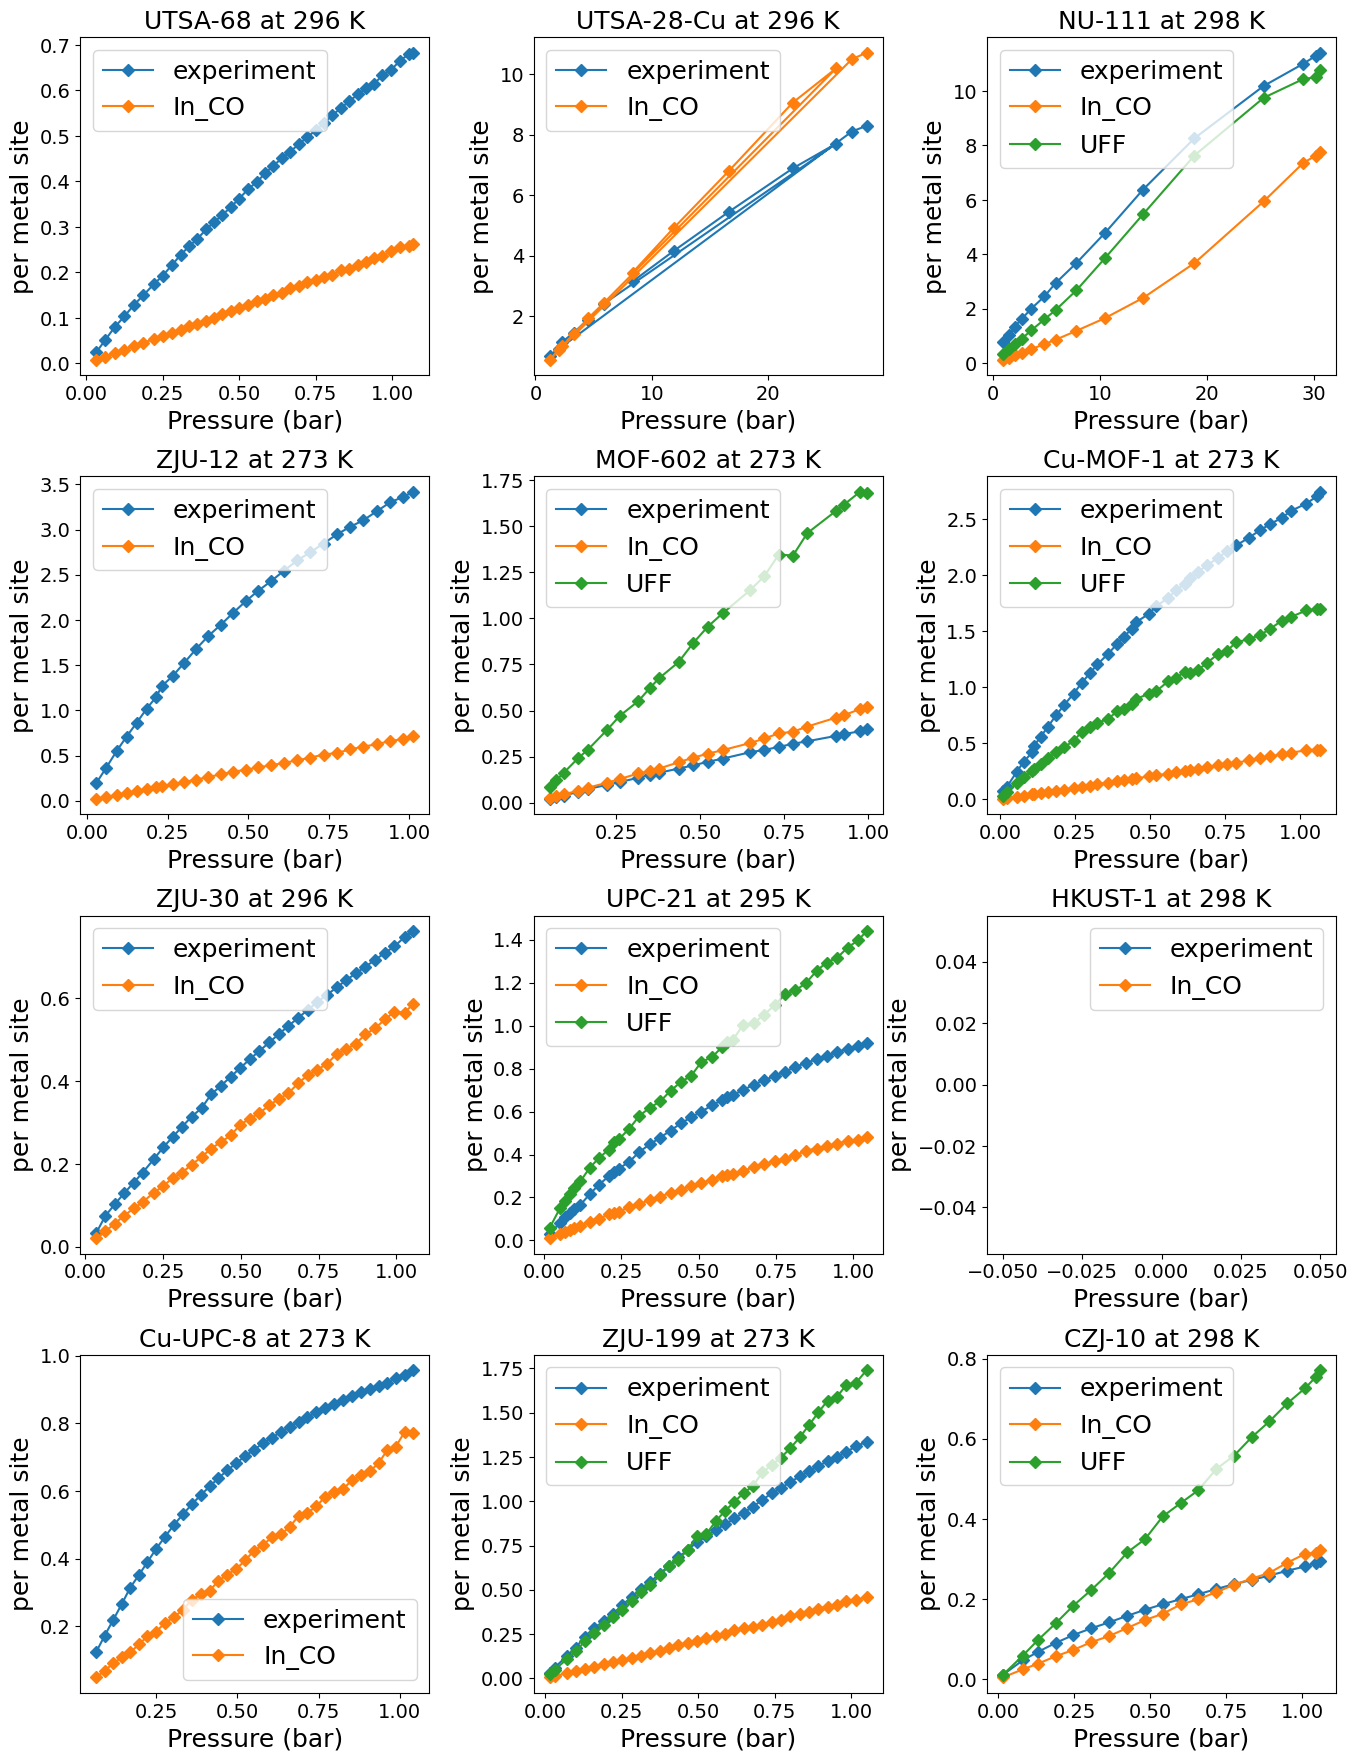

In [3]:
from aiidamof import AiidaMofs, plot_isotherm
from aiidamof import merge_aiida_mofs

UFF_logfile ="UFF_Cu.log"
newFF_logfile =  "In_CO_Cu.log"
aiidamofs = merge_aiida_mofs(AiidaMofs(newFF_logfile),AiidaMofs(UFF_logfile))
plot_isotherm(aiidamofs)

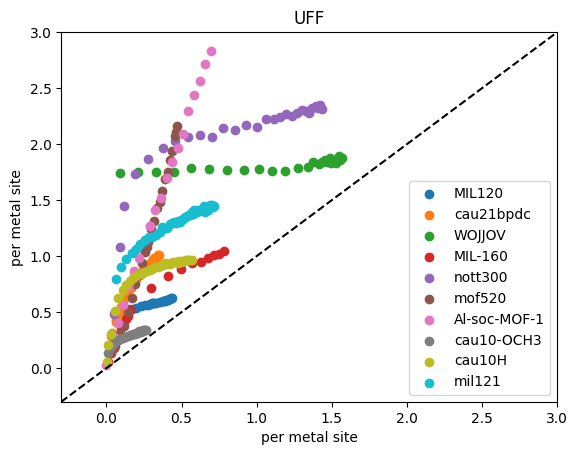

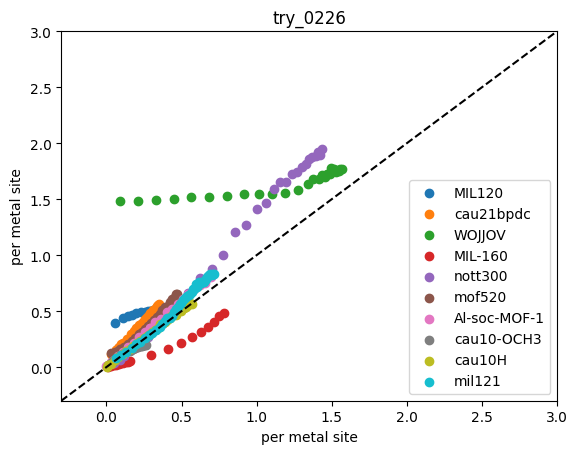

In [14]:
Isotherm_unit = "per metal site" 

import matplotlib.pyplot as plt
import numpy as np


max_loading = 3
FF_name = 'UFF'
# plot reference
plt.plot(np.linspace(-max_loading, max_loading, 100), np.linspace(-max_loading, max_loading, 100), 'k--')
# plot point
for aiidamof in aiidamofs:
    plt.scatter(aiidamof.co_isotherms["experiment"], aiidamof.co_isotherms[FF_name], label=aiidamof.mofname)
plt.xlim(-0.1*max_loading, max_loading)
plt.ylim(-0.1*max_loading, max_loading)
plt.xlabel(Isotherm_unit)
plt.ylabel(Isotherm_unit)
plt.title(FF_name)
plt.legend()
plt.show()


FF_name = 'try_0226'
# plot reference
plt.plot(np.linspace(-max_loading, max_loading, 100), np.linspace(-max_loading, max_loading, 100), 'k--')
# plot point
for aiidamof in aiidamofs:
    plt.scatter(aiidamof.co_isotherms["experiment"], aiidamof.co_isotherms[FF_name], label=aiidamof.mofname)
plt.xlim(-0.1*max_loading, max_loading)
plt.ylim(-0.1*max_loading, max_loading)
plt.xlabel(Isotherm_unit)
plt.ylabel(Isotherm_unit)
plt.title(FF_name)
plt.legend()
plt.show()

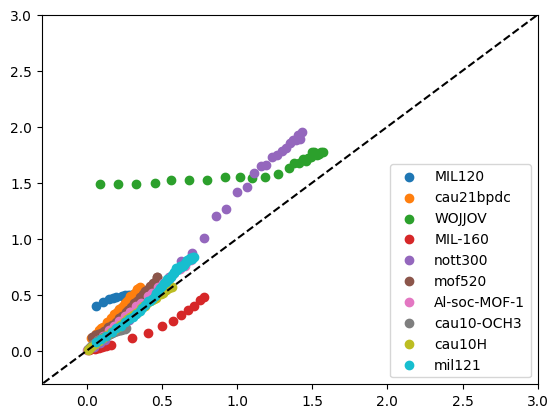

In [12]:
import matplotlib.pyplot as plt
import numpy as np
FF_name = 'try_0226'

max_loading = 3

# plot reference
plt.plot(np.linspace(-max_loading, max_loading, 100), np.linspace(-max_loading, max_loading, 100), 'k--')
# plot point
for aiidamof in aiidamofs:
    plt.scatter(aiidamof.co_isotherms["experiment"], aiidamof.co_isotherms[FF_name], label=aiidamof.mofname)
plt.xlim(-0.1*max_loading, max_loading)
plt.ylim(-0.1*max_loading, max_loading)
plt.legend()

In [7]:
import os

path = "/home/yutao/project/Mg-MOF/HAFVUH/RSM0639.cif"
parts = os.path.normpath(path).split(os.sep)

print(parts)

['', 'home', 'yutao', 'project', 'Mg-MOF', 'HAFVUH', 'RSM0639.cif']


In [19]:
structure_folder = "/home/yutao/project/Mg-MOF/MOF-889/"
SET_temperature = 273
Index = 1
Transfer_unit = 14.835925/4.398046  #It also depends on different structure, it also contains transfer from STP to mol/Kg
cif_path = os.path.join(structure_folder, "RSM3831.cif")
scaling_factors = (2,2,1)  
experiment_path = os.path.join(structure_folder, f"{SET_temperature}K_short.csv")
dest_path = f"/home/yutao/project/MIL-120/traj{Index}/"
copy_to_path = f"./traj{Index}/"
ff_path = f'/home/yutao/project/aiida/applications/ff_{Index}.json'


In [20]:
def compute_molar_mass(atoms):
    return sum(atom.mass for atom in atoms)
atoms = read(cif_path)
molar_mass = compute_molar_mass(atoms)
print(molar_mass/1000-Transfer_unit)

3.681213337269895e-05


In [10]:
molar_mass = compute_molar_mass(atoms)

NameError: name 'compute_molar_mass' is not defined

In [15]:
log_path

'/home/yutao/project/aiida/applications/UFF_Mg.log'

In [5]:
log_name = "try_0226_Al_0430.log"
log_path = os.path.join(aiida_path, log_name)
aiida_mofs = AiidaMofs(log_path)

# Get an AiidaMof object
aiida_mof = aiida_mofs[0]

# Print the folder of the AiidaMof object
for aiida_mof in aiida_mofs:
    print(aiida_mof.folder)

NameError: name 'os' is not defined

CIF files: ['MOF-889', 'CPM-201', 'CPM-203', 'HAFVUH']
Temperatures: [273, 273, 273, 273]
Isotherm PKs: [778558, 778602, 778646, 778692]
Binding PKs: [778574, 778619, 778663, 778707]


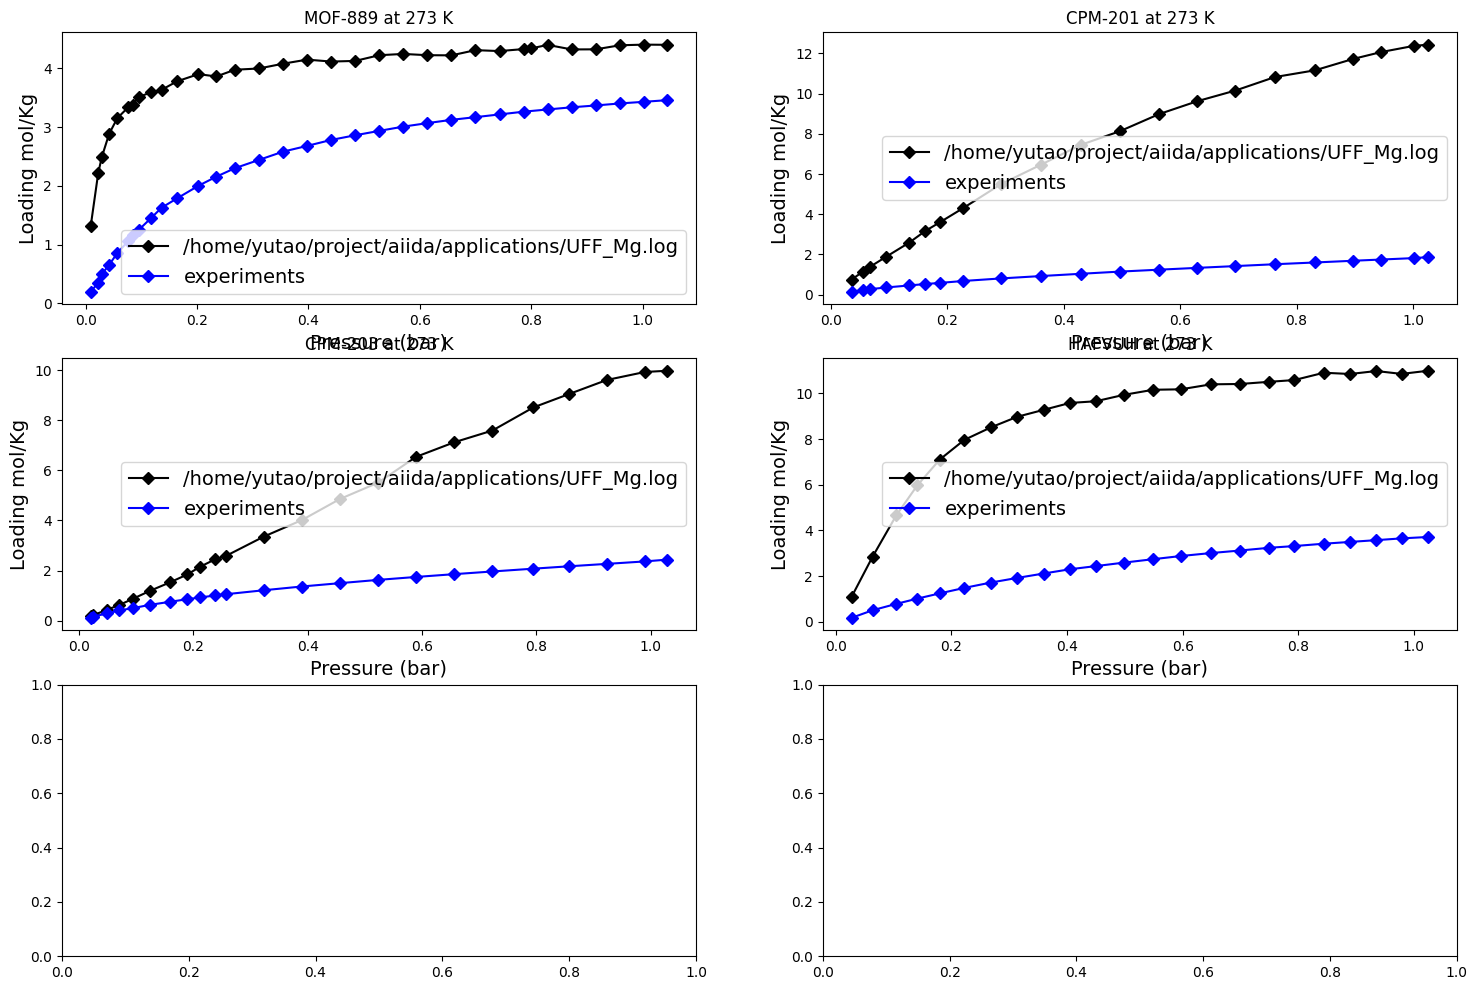

In [5]:
structure_path = "/home/yutao/project/Mg-MOF/"

import re
import os
log_name = "UFF_Mg.log"

folder_names = []
temperatures = []
isotherm_pks = []
binding_pks = []

log_name = os.path.join(aiida_path, log_name)
with open(log_name, 'r') as f:
    for line in f:
        if 'The tested cif is:' in line:
            cif_file = re.search(r'The tested cif is:  (.*)', line).group(1)
            folder_name = os.path.basename(os.path.dirname(cif_file))
            folder_names.append(folder_name)
        elif 'The simulation temperature is:' in line:
            temperature = re.search(r'The simulation temperature is:  (\d+)', line).group(1)
            temperatures.append(int(temperature))
        elif 'This is the final pk values for isotherm workflow:' in line:
            isotherm_pk = re.search(r'This is the final pk values for isotherm workflow:  (\d+)', line).group(1)
            isotherm_pks.append(int(isotherm_pk))
        elif 'This is the final pk values for binding sites workflow:' in line:
            binding_pk = re.search(r'This is the final pk values for binding sites workflow:  (\d+)', line).group(1)
            binding_pks.append(int(binding_pk))

print("CIF files:", folder_names)
print("Temperatures:", temperatures)
print("Isotherm PKs:", isotherm_pks)
print("Binding PKs:", binding_pks)


import matplotlib.pyplot as plt
import math

fz = 14

Number_of_pictures = len(folder_names)
fig, axs = plt.subplots(3, math.ceil(Number_of_pictures/3), figsize=(3*6, math.ceil(Number_of_pictures/3)*6))
idx_ls = []
for i in range(3):
    for j in range(math.ceil(Number_of_pictures/3)):
        idx_ls.append([i,j])
idx = 0
for mof, temperature, isotherm_pk, binding_pk in zip(folder_names, temperatures, isotherm_pks, binding_pks):
    
    dest_path = os.path.join(structure_path, mof)
    isotherm_path = [file for file in os.listdir(dest_path) if file.endswith("K.csv")]
    isotherm_path = os.path.join(dest_path, isotherm_path[0])

    try:
        pk = isotherm_pk
        qb = QueryBuilder()
        qb.append(WorkChainNode, filters={'id':pk}, tag="workchain")
        qb.append(Dict, with_incoming="workchain")
        outdict_ls = qb.all()[:]
        p_ls = outdict_ls[0][0].get_dict()['isotherm']['pressure']
        loading_ls = outdict_ls[0][0].get_dict()['isotherm']['loading_absolute_average']
    except:
        print("Isotherm workflow failed for ", isotherm_pk, mof)
        continue
    ax = axs[idx_ls[idx][0], idx_ls[idx][1]]
    ax.plot(p_ls, loading_ls, marker='D',c='black',label=log_name)
    arr_3 = np.loadtxt(isotherm_path, delimiter=',')
    ax.plot(arr_3[:,0],arr_3[:,1]/22.4,marker='D',c='blue', label = r"experiments")
    
    ax.set_title(f"{mof} at {temperature} K")
    ax.legend(fontsize=fz)
    ax.set_ylabel("Loading mol/Kg", fontsize=fz)
    ax.set_xlabel("Pressure (bar)", fontsize=fz)
    idx += 1


In [17]:
from aiida.orm import QueryBuilder, Group, WorkChainNode, Dict, StructureData, CifData
import aiida
import numpy as np
import pytest
import os
from ase.io import read, write
aiida.load_profile()
import pytest

name_ls = []
ff_ls = []
dft_ls = []

for mof, binding_pk in zip(folder_names, binding_pks):
    qb = QueryBuilder()
    #qb.append(WorkChainNode, filters={'id':binding_pk})
    qb.append(WorkChainNode, filters={'id':binding_pk}, tag="workchain")
    workchain = qb.all()[:][0][0]
    if not workchain.is_finished:
        print(f"WorkChain with pk={binding_pk} has not finished yet.")
        continue
    #qb = QueryBuilder()
    #qb.append(WorkChainNode, filters={'id':binding_pk}, tag="workchain")
    qb.append(Dict, with_incoming="workchain")
    outdict_ls = qb.all()[:]
    #print("This is the number of out directories",len(outdict_ls))
    if len(outdict_ls)!=2:
        print(f"Wrong output dict: {len(outdict_ls)}, in workchain {binding_pk}, {mof}")
        continue
    try:
        ff_energy = outdict_ls[0][0]["energy_host/ads_tot_final"][-1]
        cp2k_energy = outdict_ls[1][0]["binding_energy_corr"]
    #print("this is ff_energy and cp2k_energy: ",ff_energy, cp2k_energy)
    #print("this is out",outdict_ls)
    except:
        ff_energy = outdict_ls[1][0]["energy_host/ads_tot_final"][-1]
        cp2k_energy = outdict_ls[0][0]["binding_energy_corr"]

    name_ls.append(mof)
    ff_ls.append(ff_energy)
    dft_ls.append(cp2k_energy)

import matplotlib.pyplot as plt
fz=16
plt.scatter(range(0,len(name_ls)),ff_ls, label=f"Binding Energy ({log_name})")
plt.scatter(range(0,len(name_ls)),dft_ls, label="Binding Energy (CP2K)")
plt.ylabel("Binding Energy KJ/mol",fontsize=fz)
#plt.xlabel("Cif file name",fontsize=fz)
plt.xticks(range(0,len(name_ls)), name_ls, rotation=30)  
plt.legend()

NameError: name 'folder_names' is not defined